# Autoencoders

<p>
CAS on Advanced Machine Learning <br>
Data Science Lab, University of Bern, 2023<br>
Prepared by Dr. Mykhailo Vladymyrov.

</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


## Libs and utils

In [1]:
import pandas as pd
import pickle
from PIL import Image
from time import time as timer



#import umap
from scipy.stats import entropy

Lets start with a simple, well understood mnist dataset.

In [2]:
import os

# set env var to allow duplicated lib 
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import einops as eo
import pathlib as pl

import matplotlib.cm as cm
from matplotlib import collections  as mc
from matplotlib import animation
%matplotlib inline

from scipy.stats import norm

from IPython.display import HTML
from IPython.display import Audio
import IPython

import tqdm.auto as tqdm

import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F

import sys
is_colab = 'google.colab' in sys.modules


In [4]:
# get mean and std of an array with numpy:
def get_mean_std(x):
    x_mean = np.mean(x)
    x_std = np.std(x)
    return x_mean, x_std

# get min and max of an array with numpy:
def get_min_max(x):
    x_min = np.min(x)
    x_max = np.max(x)
    return x_min, x_max

def is_iterable(obj):
    try:
        iter(obj)
    except Exception:
        return False
    else:
        return True
    
def type_len(obj):
    t = type(obj)
    if is_iterable(obj):
        sfx = f', shape: {obj.shape}' if t == np.ndarray else ''
        print(f'type: {t}, len: {len(obj)}{sfx}')
    else:    
        print(f'type: {t}, len: {len(obj)}')

In [5]:
def to_np_showable(pt_img):
  np_im = pt_img.detach().cpu().numpy()
  if len(np_im.shape) == 4:
    np_im = np_im[0]

  if np_im.shape[0] > 3:
    np_im = np_im[-3:]

  return (eo.rearrange(np_im, 'c w h -> w h c')/2+.5).clip(0., 1.)

def plot_im(im, is_torch=True):
  plt.imshow(to_np_showable(im) if is_torch else im, cmap='gray')
  plt.show()
  plt.close()

def plot_im_samples(ds, n=5, is_torch=False):
  fig, axs = plt.subplots(1, n, figsize=(16, n))
  for i, image in enumerate(ds[:n]):
      axs[i].imshow(to_np_showable(image) if is_torch else image, cmap='gray')
      axs[i].set_axis_off()
  plt.show()
  plt.close()

In [6]:
# merging 2d matrix of images in 1 image
def mosaic(mtr_of_ims):
  ny = len(mtr_of_ims)
  assert(ny != 0)

  nx = len(mtr_of_ims[0])
  assert(nx != 0)

  im_sh = mtr_of_ims[0][0].shape

  assert (2 <= len(im_sh) <= 3)
  multichannel = len(im_sh) == 3

  if multichannel:
    h, w, c = im_sh
  else:
    h, w = im_sh

  h_c = h * ny + 1 * (ny-1)
  w_c = w * nx + 1 * (nx-1)

  canv_sh = (h_c, w_c, c) if multichannel else (h_c, w_c)
  canvas = np.ones(shape=canv_sh, dtype=np.float32)*0.5

  for iy, row in enumerate(mtr_of_ims):
    y_ofs = iy * (h + 1)
    for ix, im in enumerate(row):
      x_ofs = ix * (w + 1)
      canvas[y_ofs:y_ofs + h, x_ofs:x_ofs + w] = im


  return canvas

In [7]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')  # use first available GPU
    else:
        device = torch.device('cpu')
    return device

In [8]:
device = get_device()
print(f'device: {device}')

device: cpu


# Draw diffusion

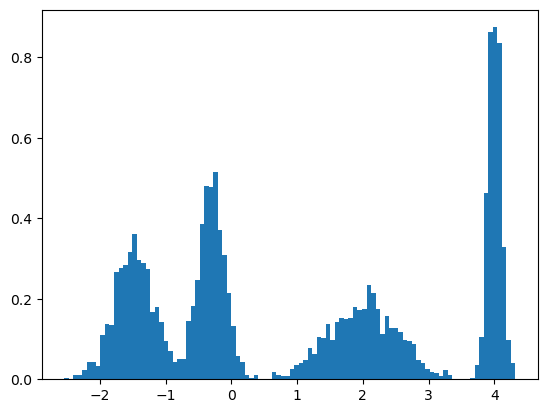

In [12]:
# make samples from normal distribution with m, s
def sample_n(m, s, n=1000):
    return np.random.normal(m, s, n)

# make samples from distributions given by list of m, s
def sample_n_mult(m_list, s_list, n=1000):
    return np.concatenate([sample_n(m, s, n) for m, s in zip(m_list, s_list)])

# make samples from distributions given by list of m, s
m = [-1.5, -.3, 2, 4]
s = [.3, .2, .5, .1]

# make samples from distributions given by list of m, s
x0 = sample_n_mult(m, s, n=1000)

# plot
plt.hist(x0, bins=100, density=True);

In [13]:
def diffuse_samples(samples, beta):
    # calc diffusion
    diffusion = np.random.normal(0, np.sqrt(beta), len(samples))
    # calc new samples
    # re-normalize samples
    samples_norm = np.sqrt(1-beta) * samples
    new_samples = samples_norm + diffusion
    return new_samples

In [23]:
beta = 0.05
x = x0

xs = [x]
for idx in range(100):
   x = diffuse_samples(x, beta) 
   xs.append(x)
   

In [24]:
%%capture

plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above animations use JavaScript

s=1
fig = plt.figure(figsize=(s*4, s*2))

ttl = plt.title(f'after itr {int(0)}')
bins = np.linspace(-5, 6, 300)
_, _, bar_container = plt.hist(xs[0], bins=bins);

# this function will be called to render each of the frames
def animate(i):
    n, _ = np.histogram(xs[i], bins)
    for count, rect in zip(n, bar_container.patches):
        rect.set_height(count)

    ttl.set_text(f'after itr {i}')

    return bar_container.patches

# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(xs))

In [25]:
ani